# Segmenting and Clustering Neighborhoods in Toronto

- Muhammad Umar Khan

In [1]:
# import all the libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline
print('Packages installed  :)')

Packages installed  :)


In [2]:
# Get the file using beautiful soup 
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content)


#### Lines until df.head() are reading the file and then into a pandas dataframe

In [3]:
soup = BeautifulSoup(str(data_html))

In [4]:
neigh = soup.find('table')

In [5]:
table_str = str(neigh.extract())

In [6]:
df = pd.read_html(table_str)[0]

In [7]:
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Drop all the rows which have Boroughs **'Not assigned'** and then reset the index. Assumed looking at the wikipedia link that the Neighborhoods with the same Postal Code appear on the same row so further cleansing didnt have to be done to satisfy requirements

In [8]:
df_dropna = df[df.Borough != 'Not assigned'].reset_index(drop=True)

In [9]:
df_dropna.rename(columns={'Postal Code' : 'PostalCode'}, inplace=True)

Check to see the shape of the dataframe

In [10]:
print(df_dropna.shape)

(103, 3)


#### Preprocess data so that Broroughs are grouped based on their name

In [11]:
df = df_dropna

In [12]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [13]:
df_grouped = df.groupby(['Borough', 'PostalCode'], 
                        as_index=False).agg(lambda x:','.join(x))
df_grouped.head(20)

,Borough,PostalCode,Neighborhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,North Toronto West
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"
5,Central Toronto,M4V,"Summerhill West, Rathnelly, South Hill, Forest..."
6,Central Toronto,M5N,Roselawn
7,Central Toronto,M5P,Forest Hill North & West
8,Central Toronto,M5R,"The Annex, North Midtown, Yorkville"
9,Downtown Toronto,M4W,Rosedale


Check to see if we have any Not assigned Neighorhoods

In [14]:
df_grouped.loc[df_grouped['Borough'].isin(["Not assigned"])]

,Borough,PostalCode,Neighborhood


So now all the requirements are met and the data is cleansed, now we just have to add the Latitude and Longitudes of each location


In [15]:
df_grouped.reset_index(drop=True)

,Borough,PostalCode,Neighborhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,North Toronto West
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"
...,...,...,...
98,York,M6C,Humewood-Cedarvale
99,York,M6E,Caledonia-Fairbanks
100,York,M6M,"Del Ray, Mount Dennis, Keelsdale and Silverthorn"
101,York,M6N,"Runnymede, The Junction North"


In [16]:
list(df_grouped.columns.values)

['Borough', 'PostalCode', 'Neighborhood']

In [17]:
df_grouped = df_grouped[['PostalCode', 'Borough', 'Neighborhood']]

In [18]:
list(df_grouped.columns.values)

['PostalCode', 'Borough', 'Neighborhood']

Rearranged the Columns so the **PostalCode** appears first

In [19]:
df_grouped.head()

,PostalCode,Borough,Neighborhood
0,M4N,Central Toronto,Lawrence Park
1,M4P,Central Toronto,Davisville North
2,M4R,Central Toronto,North Toronto West
3,M4S,Central Toronto,Davisville
4,M4T,Central Toronto,"Moore Park, Summerhill East"


Now we are going to create a new table with the Latitudes and Longitudes corresponding to the different PostalCodes

In [20]:
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)

In [21]:
geo_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Next We Will merge the data. We will make the actual data equal to the temporary data frame we are working with becauase we are happy with it and then we will merge it based on the postal code.

In [22]:
df = df_grouped

In [23]:
df = pd.merge(df, geo_df, on='PostalCode')

In [24]:
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
2,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
3,M4S,Central Toronto,Davisville,43.704324,-79.388790
4,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160


## Map of Toronto

In [25]:
# create map of Toronto using latitude and longitude values
latitude = 43.653225
longitude = -79.383186
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.75,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Next we will define foursquare Credentials

In [26]:

CLIENT_ID = 'XE50LMYN3EHYK0QQ1AUPUEO5IAN15PHB3SR0ZRZFU11I52B0' # your Foursquare ID
CLIENT_SECRET = 'XWZMXWRGWW2RL2IKE2NEFEKQP4B24O30XNB4WXUYIG4I33RP' # your Foursquare Secret
VERSION = 20200514 # Foursquare API version

print('Credentials Stored')


Credentials Stored


In [27]:
df.loc[0, 'Neighborhood']

'Lawrence Park'

We will analyze the first Neighborhood, Lawrence Park

In [28]:
law_lat = df.loc[0, 'Latitude']
law_long = df.loc[0, 'Longitude']
law_name = df.loc[0, 'Neighborhood']


print('Latitude and longitude values of {} are {}, {}.'.format(law_name, 
                                                               law_lat, 
                                                               law_long))

Latitude and longitude values of Lawrence Park are 43.7280205, -79.3887901.


#### Now, let's get the top 100 venues that are in Lawrence Park within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [29]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    law_lat, 
    law_long, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=XE50LMYN3EHYK0QQ1AUPUEO5IAN15PHB3SR0ZRZFU11I52B0&client_secret=XWZMXWRGWW2RL2IKE2NEFEKQP4B24O30XNB4WXUYIG4I33RP&v=20200514&ll=43.7280205,-79.3887901&radius=500&limit=100'

In [30]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ebe24a5d03993001b1fb13d'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Toronto',
  'headerFullLocation': 'Toronto',
  'headerLocationGranularity': 'city',
  'totalResults': 3,
  'suggestedBounds': {'ne': {'lat': 43.7325205045, 'lng': -79.3825744605273},
   'sw': {'lat': 43.7235204955, 'lng': -79.3950057394727}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '50e6da19e4b0d8a78a0e9794',
       'name': 'Lawrence Park Ravine',
       'location': {'address': '3055 Yonge Street',
        'crossStreet': 'Lawrence Avenue East',
        'lat': 43.72696303913755,
        'lng': -79.39438246708775,
        'labeledL

In [31]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we will clean the json and structure it into a *pandas* dataframe.

In [32]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Lawrence Park Ravine,Park,43.726963,-79.394382
1,Zodiac Swim School,Swim School,43.728532,-79.382860
2,TTC Bus #162 - Lawrence-Donway,Bus Line,43.728026,-79.382805


We want to know how many venues around Lawrence Avenue were found

In [33]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

3 venues were returned by Foursquare.


That was just one Neighborhood in Toronto, What if we want all? We will use a forloop to run through all the neighborhoods in toronto and repeat the same process as above.

In [34]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we will run the above function on each neighborhood and create a new dataframe called toronto_venues

In [35]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Roselawn
Forest Hill North & West
The Annex, North Midtown, Yorkville
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Queen's Park, Ontario Provincial Government
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Business reply mail Processing Centre
Parkview Hill, Woodbine Gardens
Woodbine Heights
Leaside
Tho

In [36]:
print(toronto_venues.shape)

(2116, 7)


In [37]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Lawrence Park,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
2,Lawrence Park,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
3,Davisville North,43.712751,-79.390197,Homeway Restaurant & Brunch,43.712641,-79.391557,Breakfast Spot
4,Davisville North,43.712751,-79.390197,Sherwood Park,43.716551,-79.387776,Park


check how many venues were returned for each neighborhood

In [38]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
...,...,...,...,...,...,...
"Wexford, Maryvale",7,7,7,7,7,7
Willowdale,39,39,39,39,39,39
Woburn,4,4,4,4,4,4


Check how many unique Venues there are that can be curated

In [39]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 272 uniques categories.


## Now we will Analyze each neighborhood

In [40]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
toronto_onehot.shape

(2116, 272)

In [42]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.050000,0.000000,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,"Wexford, Maryvale",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
89,Willowdale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.025641,0.0,0.0,0.0,0.0,0.0
90,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
91,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.111111,0.000000,0.0,0.0,0.0,0.0,0.0


#### Let's print each neighborhood along with the top 5 most common venues

In [43]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0                     Lounge   0.2
1             Breakfast Spot   0.2
2  Latin American Restaurant   0.2
3             Clothing Store   0.2
4               Skating Rink   0.2


----Alderwood, Long Branch----
          venue  freq
0   Pizza Place  0.25
1   Coffee Shop  0.12
2           Gym  0.12
3  Skating Rink  0.12
4      Pharmacy  0.12


----Bathurst Manor, Wilson Heights, Downsview North----
            venue  freq
0     Coffee Shop  0.10
1            Bank  0.10
2        Pharmacy  0.05
3   Shopping Mall  0.05
4  Sandwich Place  0.05


----Bayview Village----
                 venue  freq
0                 Café  0.25
1                 Bank  0.25
2   Chinese Restaurant  0.25
3  Japanese Restaurant  0.25
4          Yoga Studio  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0  Italian Restaurant  0.09
1         Coffee Shop  0.09
2     Thai Restaurant  0.09
3      Sandwich Place  0.09
4          Restaurant

4  Modern European Restaurant   0.0


----Humewood-Cedarvale----
          venue  freq
0         Field  0.25
1       Dog Run  0.25
2  Hockey Arena  0.25
3         Trail  0.25
4   Yoga Studio  0.00


----India Bazaar, The Beaches West----
                  venue  freq
0        Sandwich Place  0.09
1  Fast Food Restaurant  0.09
2          Liquor Store  0.05
3            Restaurant  0.05
4      Sushi Restaurant  0.05


----Kennedy Park, Ionview, East Birchmount Park----
               venue  freq
0   Department Store   0.2
1  Convenience Store   0.2
2        Coffee Shop   0.2
3     Discount Store   0.2
4      Train Station   0.2


----Kensington Market, Chinatown, Grange Park----
                   venue  freq
0                   Café  0.09
1            Coffee Shop  0.07
2                 Bakery  0.05
3     Mexican Restaurant  0.05
4  Vietnamese Restaurant  0.05


----Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens----
               venue  freq
0  Mobile Phone Sho

4                 Coffee Shop  0.17


----West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale----
                        venue  freq
0                 Golf Course   1.0
1                 Yoga Studio   0.0
2                 Men's Store   0.0
3  Modern European Restaurant   0.0
4           Mobile Phone Shop   0.0


----Westmount----
                venue  freq
0      Sandwich Place  0.14
1      Discount Store  0.14
2         Pizza Place  0.14
3  Chinese Restaurant  0.14
4         Coffee Shop  0.14


----Wexford, Maryvale----
                       venue  freq
0  Middle Eastern Restaurant  0.29
1                Auto Garage  0.14
2             Breakfast Spot  0.14
3                     Bakery  0.14
4              Shopping Mall  0.14


----Willowdale----
              venue  freq
0       Pizza Place  0.08
1       Coffee Shop  0.08
2  Ramen Restaurant  0.08
3    Sandwich Place  0.05
4              Café  0.05


----Woburn----
                venue  freq
0         Coffee Sh

Now we will put that into a pandas dataframe

In [44]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now we will list the top 10 venues for each of the neighborhood

In [45]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(11)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Skating Rink,Latin American Restaurant,Lounge,Breakfast Spot,Clothing Store,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run
1,"Alderwood, Long Branch",Pizza Place,Gym,Skating Rink,Coffee Shop,Pub,Pharmacy,Sandwich Place,Women's Store,Discount Store,Department Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Pharmacy,Deli / Bodega,Supermarket,Ice Cream Shop,Sushi Restaurant,Middle Eastern Restaurant,Restaurant,Diner
3,Bayview Village,Café,Chinese Restaurant,Bank,Japanese Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Dessert Shop
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Restaurant,Coffee Shop,Thai Restaurant,Butcher,Café,Indian Restaurant,Sushi Restaurant,Pizza Place
5,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Bakery,Seafood Restaurant,Restaurant,Cheese Shop,Café,Nightclub,Japanese Restaurant
6,"Birch Cliff, Cliffside West",College Stadium,General Entertainment,Skating Rink,Café,Comic Shop,Dessert Shop,Colombian Restaurant,Event Space,Ethiopian Restaurant,Electronics Store
7,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Pet Store,Bar,Intersection,Bakery,Italian Restaurant,Climbing Gym,Restaurant
8,Business reply mail Processing Centre,Gym / Fitness Center,Pizza Place,Skate Park,Smoke Shop,Brewery,Spa,Farmers Market,Fast Food Restaurant,Burrito Place,Restaurant
9,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Terminal,Airport Lounge,Airport Service,Boat or Ferry,Rental Car Location,Plane,Coffee Shop,Harbor / Marina,Bar,Airport Food Court


### Now We will Cluster these Neighborhoods

In [46]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5


create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

Lets try using the **Elbow** method to find the optimum K value

In [47]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = toronto_grouped.drop(['Neighborhood'], axis=1)

In [48]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [49]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [50]:

scores = [get_inertia(x) for x in range(2, 21)]

Text(0, 0.5, 'Error')

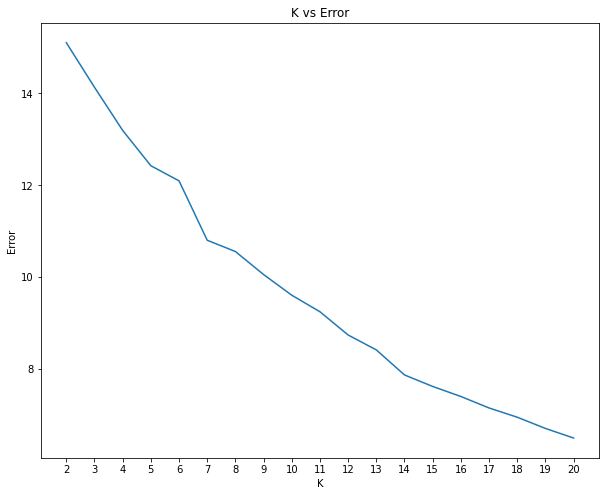

In [51]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores)
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

We can see from above that the point that sharply turns and reduces the speed of the error is ad k=7

In [52]:
kclusters = 7

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 5, 1, 1, 1, 1, 1, 1, 1, 1])

In [53]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

toronto_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,2.0,Park,Bus Line,Swim School,Dog Run,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Department Store
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197,1.0,Park,Breakfast Spot,Hotel,Food & Drink Shop,Department Store,Sandwich Place,Gym,Airport Service,Fast Food Restaurant,Falafel Restaurant
2,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,1.0,Clothing Store,Coffee Shop,Spa,Seafood Restaurant,Salon / Barbershop,Restaurant,Café,Chinese Restaurant,Pet Store,Park
3,M4S,Central Toronto,Davisville,43.704324,-79.388790,1.0,Pizza Place,Sandwich Place,Dessert Shop,Gym,Italian Restaurant,Sushi Restaurant,Coffee Shop,Café,Pharmacy,Seafood Restaurant
4,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,2.0,Park,Playground,Restaurant,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant


In [54]:
toronto_merged.tail()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
98,M6C,York,Humewood-Cedarvale,43.693781,-79.428191,1.0,Trail,Field,Dog Run,Hockey Arena,Women's Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
99,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512,2.0,Park,Pool,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Deli / Bodega
100,M6M,York,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",43.691116,-79.476013,1.0,Discount Store,Bar,Convenience Store,Sandwich Place,Women's Store,Doner Restaurant,Diner,Distribution Center,Dog Run,Donut Shop
101,M6N,York,"Runnymede, The Junction North",43.673185,-79.487262,1.0,Brewery,Bus Line,Convenience Store,Breakfast Spot,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Women's Store
102,M9N,York,Weston,43.706876,-79.518188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### We see that some Clusters or Venues have invalid types so we will drop them

In [55]:
#toronto_drop = toronto_merged[toronto_merged.Cluster_Labels != 'NaN'].reset_index(drop=True)
toronto_merged.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

### Now we deleted all rows that have empty values and we will Visualize

In [66]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.75).add_to(map_clusters)
       
map_clusters

## Cluster 1

In [58]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
77,Scarborough,0.0,Rental Car Location,Breakfast Spot,Mexican Restaurant,Bank,Intersection,Medical Center,Electronics Store,Drugstore,Donut Shop,Doner Restaurant


## Cluster 2

In [59]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Central Toronto,1.0,Park,Breakfast Spot,Hotel,Food & Drink Shop,Department Store,Sandwich Place,Gym,Airport Service,Fast Food Restaurant,Falafel Restaurant
2,Central Toronto,1.0,Clothing Store,Coffee Shop,Spa,Seafood Restaurant,Salon / Barbershop,Restaurant,Café,Chinese Restaurant,Pet Store,Park
3,Central Toronto,1.0,Pizza Place,Sandwich Place,Dessert Shop,Gym,Italian Restaurant,Sushi Restaurant,Coffee Shop,Café,Pharmacy,Seafood Restaurant
5,Central Toronto,1.0,Coffee Shop,Pub,American Restaurant,Supermarket,Bank,Fried Chicken Joint,Sports Bar,Pizza Place,Bagel Shop,Restaurant
6,Central Toronto,1.0,Garden,Health & Beauty Service,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
...,...,...,...,...,...,...,...,...,...,...,...,...
96,West Toronto,1.0,Breakfast Spot,Gift Shop,Bookstore,Dog Run,Dessert Shop,Bar,Eastern European Restaurant,Coffee Shop,Restaurant,Italian Restaurant
97,West Toronto,1.0,Coffee Shop,Café,Pizza Place,Bookstore,Sushi Restaurant,Restaurant,Pub,Italian Restaurant,Diner,Sandwich Place
98,York,1.0,Trail,Field,Dog Run,Hockey Arena,Women's Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
100,York,1.0,Discount Store,Bar,Convenience Store,Sandwich Place,Women's Store,Doner Restaurant,Diner,Distribution Center,Dog Run,Donut Shop


## Cluster 3

In [60]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Toronto,2.0,Park,Bus Line,Swim School,Dog Run,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Department Store
4,Central Toronto,2.0,Park,Playground,Restaurant,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
9,Downtown Toronto,2.0,Park,Trail,Playground,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
37,East York,2.0,Park,Coffee Shop,Convenience Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
40,Etobicoke,2.0,Park,Pool,River,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Deli / Bodega,Distribution Center
57,North York,2.0,Park,Bank,Bar,Convenience Store,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
59,North York,2.0,Park,Food & Drink Shop,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Falafel Restaurant
89,Scarborough,2.0,Park,Playground,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
99,York,2.0,Park,Pool,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Deli / Bodega


## Cluster 4

In [62]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
75,Scarborough,3.0,Fast Food Restaurant,Department Store,Fabric Shop,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant


## Cluster 5

In [63]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
39,Etobicoke,5.0,Pizza Place,Gym,Skating Rink,Coffee Shop,Pub,Pharmacy,Sandwich Place,Women's Store,Discount Store,Department Store
47,Etobicoke,5.0,Bus Line,Pizza Place,Sandwich Place,Mobile Phone Shop,Women's Store,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
71,North York,5.0,Pizza Place,Japanese Restaurant,Asian Restaurant,Pub,Women's Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
73,North York,5.0,Pizza Place,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore


## Cluster 6

In [64]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
80,Scarborough,6.0,Playground,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
